# B-O LID - Accelerated Test

## Example: Boron-oxygen light-induced degradation (B-O LID) progression in accelerated tests


This library can also be used to model B-O LID, as the defect states and transitions can be modeled in the same way as LETID. See kinetic_parameters.json for B-O LID kinetic parameters used in this example.

In this example, we will model B-O LID progression in a test similar to [IEC 61215 MQT 19.1](https://webstore.iec.ch/publication/61215) IEC 61215 MQT 19.1, which prescribes $\ge $ 10 $kWh/m^2$ of 1-sun illumination with maximum power point tracking at  $50\degree C$.

**Objectives:**
1. Define necessary solar cell device parameters
2. Define necessary degradation parameters: degraded lifetime and defect states, this time using B-O LID kinetics
3. Create timeseries of temperature and current injection
4. Run through timeseries, calculating defect states
5. Calculate device degradation and plot




In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.3.3

In [2]:
from pvdeg import letid, collection, utilities, DATA_DIR

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib

In [3]:
# This information helps with debugging and getting support :)
import sys
import platform
import pvdeg

print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pvlib version ", pvlib.__version__)
print("pvdeg version ", pvdeg.__version__)

Working on a  Windows 11
Python version  3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
Pandas version  2.2.3
pvlib version  0.13.0
pvdeg version  0.5.1.dev623+g51cc68b8e.d20250905


## Device parameters
To define a device, we need to define several important quantities about the device: wafer thickness (in $\mu m$), rear surface recombination velocity (in cm/s), and cell area (in cm<sup>2</sup>).

In [4]:
wafer_thickness = 180  # um
s_rear = 46  # cm/s
cell_area = 243  # cm^2

<b> Other device parameters </b>

Other required parameters are base diffusivity (in $cm^2/s$), and optical generation profile, which allow us to estimate current collection in the device.

In [5]:
generation_df = pd.read_excel(
    os.path.join(DATA_DIR, "PVL_GenProfile.xlsx"), header=0
)  # this is an optical generation profile generated by PVLighthouse's OPAL2 default model for 1-sun, normal incident AM1.5 sunlight on a 180-um thick SiNx-coated, pyramid-textured wafer.
generation = generation_df["Generation (cm-3s-1)"]
depth = generation_df["Depth (um)"]

d_base = 27  # cm^2/s electron diffusivity. See https://www2.pvlighthouse.com.au/calculators/mobility%20calculator/mobility%20calculator.aspx for details

## Degradation parameters
To model the device's degradation, we need to define several more important quantities about the degradation the device will experience. These include undegraded and degraded lifetime (in $\mu s$).

In [6]:
tau_0 = 115  # us, carrier lifetime in non-degraded states, e.g. LETID/LID states A or C
tau_deg = 55  # us, carrier lifetime in fully-degraded state, e.g. LETID/LID state B

Let's see how much maximum power degradation these parameters will result in:

In [7]:
letid.calc_pmp_loss_from_tau_loss(
    tau_0, tau_deg, cell_area, wafer_thickness, s_rear
)  # returns % power loss, pmp_0, pmp_deg

(np.float64(0.03495240755084558),
 np.float64(5.663466529792824),
 np.float64(5.465514739492932))

<b>Remaining degradation parameters:</b>

The rest of the quantities to define are: the initial percentage of defects in each state (A, B, and C), and the dictionary of mechanism parameters.

In this example, we'll assume the device starts in the fully-undegraded state (100% state A), and we'll use the parameters for B-O LID

In [8]:
# starting defect state percentages
nA_0 = 100
nB_0 = 0
nC_0 = 0

In [9]:
# Here's a list of the possible sets of kinetic parameters from kinetic_parameters.json:
utilities.get_kinetics()

('Choose a set of kinetic parameters:',
 ['repins',
  'repins_best_case',
  'kwapil',
  'bredemeier',
  'wyller_wafer',
  'wyller_cell',
  'graf',
  'dark letid',
  'bo-lid',
  'Lit BO-LID + fit to Qcells destab'])

In [10]:
mechanism_params = utilities.get_kinetics("bo-lid")
print(mechanism_params)

{'mechanism': 'BO-LID', 'v_ab': 4000.0, 'v_ba': 10000000000000.0, 'v_bc': 12500000000.0, 'v_cb': 532000.0, 'ea_ab': 0.475, 'ea_ba': 1.32, 'ea_bc': 0.98, 'ea_cb': 0.87, 'suns_ab': 0.1, 'suns_bc': 2.7, 'temperature_ab': 400, 'temperature_bc': 434, 'tau_ab': 140, 'tau_bc': 165, 'x_ab': 0, 'x_ba': 1, 'x_bc': 0, 'structure_ab': 'wafer', 'structure_bc': 'wafer', 'thickness_ab': 200, 'thickness_bc': 200, 'srv_ab': 0, 'srv_bc': 0, 'comments': ''}


## Set up timeseries
In this example, we are going to model test with constant temperature and injection. IEC 61215 MQT 19.1 prescribes 10 $kWh/m^2$ of 1-sun illumination (i.e., 10 hours of 1-sun) with maximum power point tracking at $50\degree C$. For most typical c-Si modules, MPP injection is roughly $I_{sc}-I_{mp}$, or roughly equal to  $0.05\times I_{sc}$. So we will set injection equal to 0.05 "suns" of injection. 

We will create a pandas datetime series and calculate the changes in defect states for each timestep. As B-O LID can initially proceed quickly, we will create a timeseries with 1-second intervals for the first 10 minutes, then proceed with 1-minute intervals

In [11]:
temperature = 50  # degrees celsius
suns = 0.05  # "suns" of injection, e.g 1-sun illumination at open circuit would be 1; dark current injection is given as a fraction of Isc, e.g., injecting Isc would be 1. For this example we assume injection is 0.05*Isc.

timesteps_initial = pd.date_range(
    start="2022-01-01 00:00:00", end="2022-01-01 00:10:00", freq="s"
)  # 10 minutes of 1-second interval timesteps. In general, we should select small timesteps unless we are sure defect reactions are proceeding very slowly
timesteps = pd.date_range(
    start="2022-01-01 00:10:00", end="2022-01-01 10:00:00", freq="min"
)  # a total of 10 hours of exposure
timesteps = pd.DataFrame(timesteps, columns=["Datetime"])
timesteps_initial = pd.DataFrame(timesteps_initial, columns=["Datetime"])

timesteps = pd.concat([timesteps_initial, timesteps])  # concatenate the two time series
timesteps = timesteps.sort_values(by="Datetime")
timesteps.reset_index(inplace=True, drop=True)

temps = np.full(len(timesteps), temperature)
injection = np.full(len(timesteps), suns)

timesteps["Temperature"] = temps
timesteps["Injection"] = injection

timesteps[["NA", "NB", "NC", "tau"]] = (
    np.nan
)  # create columns for defect state percentages and lifetime, fill with NaNs for now, to fill iteratively below

timesteps.loc[0, ["NA", "NB", "NC"]] = (
    nA_0,
    nB_0,
    nC_0,
)  # assign first timestep defect state percentages
timesteps.loc[0, "tau"] = letid.tau_now(
    tau_0, tau_deg, nB_0
)  # calculate tau for the first timestep

In [12]:
for index, timestep in timesteps.iterrows():
    # first row tau has already been assigned
    if index == 0:
        pass

    # loop through rows, new tau calculated based on previous NB. Reaction proceeds based on new tau.
    else:
        n_A = timesteps.at[index - 1, "NA"]
        n_B = timesteps.at[index - 1, "NB"]
        n_C = timesteps.at[index - 1, "NC"]

        tau = letid.tau_now(tau_0, tau_deg, n_B)
        jsc = collection.calculate_jsc_from_tau_cp(
            tau, wafer_thickness, d_base, s_rear, generation, depth
        )

        temperature = timesteps.at[index, "Temperature"]
        injection = timesteps.at[index, "Injection"]

        # calculate defect reaction kinetics: reaction constant and carrier concentration factor.
        k_AB = letid.k_ij(
            mechanism_params["v_ab"], mechanism_params["ea_ab"], temperature
        )
        k_BA = letid.k_ij(
            mechanism_params["v_ba"], mechanism_params["ea_ba"], temperature
        )
        k_BC = letid.k_ij(
            mechanism_params["v_bc"], mechanism_params["ea_bc"], temperature
        )
        k_CB = letid.k_ij(
            mechanism_params["v_cb"], mechanism_params["ea_cb"], temperature
        )

        x_ab = letid.carrier_factor(
            tau,
            "ab",
            temperature,
            injection,
            jsc,
            wafer_thickness,
            s_rear,
            mechanism_params,
        )
        x_ba = letid.carrier_factor(
            tau,
            "ba",
            temperature,
            injection,
            jsc,
            wafer_thickness,
            s_rear,
            mechanism_params,
        )
        x_bc = letid.carrier_factor(
            tau,
            "bc",
            temperature,
            injection,
            jsc,
            wafer_thickness,
            s_rear,
            mechanism_params,
        )

        # calculate the instantaneous change in NA, NB, and NC
        dN_Adt = (k_BA * n_B * x_ba) - (k_AB * n_A * x_ab)
        dN_Bdt = (
            (k_AB * n_A * x_ab) + (k_CB * n_C) - ((k_BA * x_ba + k_BC * x_bc) * n_B)
        )
        dN_Cdt = (k_BC * n_B * x_bc) - (k_CB * n_C)

        t_step = (
            timesteps.at[index, "Datetime"] - timesteps.at[index - 1, "Datetime"]
        ).total_seconds()

        # assign new defect state percentages
        timesteps.at[index, "NA"] = n_A + dN_Adt * t_step
        timesteps.at[index, "NB"] = n_B + dN_Bdt * t_step
        timesteps.at[index, "NC"] = n_C + dN_Cdt * t_step

## Finish calculating degraded device parameters.
Now that we have calculated defect states, we can calculate all the quantities that depend on defect states.

In [13]:
timesteps["tau"] = letid.tau_now(tau_0, tau_deg, timesteps["NB"])

# calculate device Jsc for every timestep. Unfortunately this requires an integration so I think we have to run through a loop. Device Jsc allows calculation of device Voc.
for index, timestep in timesteps.iterrows():
    jsc_now = collection.calculate_jsc_from_tau_cp(
        timesteps.at[index, "tau"], wafer_thickness, d_base, s_rear, generation, depth
    )
    timesteps.at[index, "Jsc"] = jsc_now
    timesteps.at[index, "Voc"] = letid.calc_voc_from_tau(
        timesteps.at[index, "tau"], wafer_thickness, s_rear, jsc_now, temperature=25
    )

In [14]:
# this function quickly calculates the rest of the device parameters: Isc, FF, max power, and normalized max power
timesteps = letid.calc_device_params(timesteps, cell_area=243)
timesteps["time (days)"] = (
    timesteps["Datetime"] - timesteps.iloc[0]["Datetime"]
).dt.total_seconds() / 86400  # create a column for days elapsed

timesteps

,Datetime,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm,time (days)
0,2022-01-01 00:00:00,50,0.05,100.000000,0.000000,0.000000e+00,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000,0.000000
1,2022-01-01 00:00:01,50,0.05,99.984366,0.015634,0.000000e+00,114.980390,41.590936,0.666324,10.106597,0.840986,5.663426,0.999993,0.000012
2,2022-01-01 00:00:02,50,0.05,99.968735,0.031265,1.016487e-07,114.960790,41.590875,0.666321,10.106583,0.840986,5.663386,0.999986,0.000023
3,2022-01-01 00:00:03,50,0.05,99.953106,0.046893,3.049294e-07,114.941200,41.590814,0.666317,10.106568,0.840985,5.663345,0.999979,0.000035
4,2022-01-01 00:00:04,50,0.05,99.937480,0.062520,6.098257e-07,114.921620,41.590753,0.666314,10.106553,0.840984,5.663305,0.999971,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,2022-01-01 09:56:00,50,0.05,0.364232,82.313555,1.732221e+01,60.591179,41.280510,0.653103,10.031164,0.838627,5.494163,0.970106,0.413889
1188,2022-01-01 09:57:00,50,0.05,0.360820,82.284870,1.735431e+01,60.601170,41.280615,0.653106,10.031189,0.838627,5.494211,0.970115,0.414583
1189,2022-01-01 09:58:00,50,0.05,0.357440,82.256164,1.738640e+01,60.611172,41.280719,0.653110,10.031215,0.838628,5.494259,0.970123,0.415278
1190,2022-01-01 09:59:00,50,0.05,0.354092,82.227438,1.741847e+01,60.621185,41.280824,0.653113,10.031240,0.838629,5.494307,0.970132,0.415972


## Plot the results



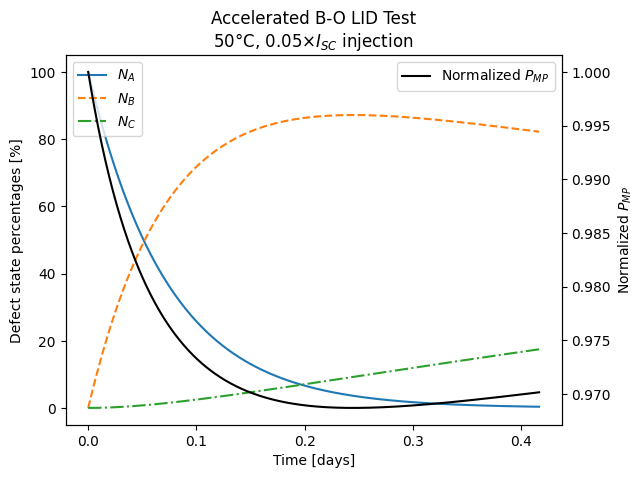

In [15]:
from cycler import cycler

plt.style.use("default")

fig, ax = plt.subplots()

ax.set_prop_cycle(
    cycler("color", ["tab:blue", "tab:orange", "tab:green"])
    + cycler("linestyle", ["-", "--", "-."])
)

ax.plot(timesteps["time (days)"], timesteps[["NA", "NB", "NC"]].values)
ax.legend(labels=["$N_A$", "$N_B$", "$N_C$"], loc="upper left")
ax.set_ylabel("Defect state percentages [%]")
ax.set_xlabel("Time [days]")

ax2 = ax.twinx()
ax2.plot(
    timesteps["time (days)"],
    timesteps["Pmp_norm"],
    c="black",
    label="Normalized $P_{MP}$",
)
ax2.legend(loc="upper right")
ax2.set_ylabel("Normalized $P_{MP}$")

ax.set_title(
    "Accelerated B-O LID Test\n"
    rf"{temperature}$\degree$C, {suns}$\times I_{{SC}}$ injection"
)

plt.show()